# Requirements

In [ ]:
# Installing Libraries

!pip install nltk
!pip install datasets
!pip install transformers[torch]
!pip install tokenizers
!pip install evaluate
!pip install rouge_score
!pip install sentencepiece
!pip install huggingface_hub
!pip install peft

## Libraries

In [ ]:
# Loading Libraries

import nltk
import evaluate
import numpy as np
from datasets import load_dataset
from datasets import Dataset
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
import pandas as pd
from peft import LoraConfig
from peft import get_peft_model
from sklearn.metrics import precision_recall_fscore_support

# Ignoring warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Setting Up Global Params

In [ ]:
# Using Google Flan t5 Base model - approx 250 M params
MODEL_NAME = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

L_RATE = 3e-4
BATCH_SIZE = 8
PER_DEVICE_EVAL_BATCH = 4
WEIGHT_DECAY = 0.01
SAVE_TOTAL_LIM = 3
NUM_EPOCHS = 20
TASK_TYPE = "SEQ_CLS"

## Dataset

In [ ]:
def add_prompt_template_mohler(mohler_df):
  ''' Loads a dataframe and appends the strings that make a single prompt text.
  Code stores this single text as a new column in the existing dataframe.
  Includes guardrails/
  Returns only two columns, the input and the target'''

  premise = "You are a grader for a undergraduate computer science course. For the given 'Question', analyze the 'Given Answer' against the 'Expected Answer' and provide a score based on the relevancy of the answer."
  question_prefix = "'Question': "
  given_prefix = "'Given Answer': "
  expect_prefix = "'Expected Answer': "
  guard_rails = "Provide your score on the given scale. In order of least relevant answer to most relevant, the score can be one of the following: 'Incorrect', 'Poor', 'Fair', 'Adequate', 'Good', 'Excellent'. Do not display any other content other than the single score word."

  mohler_df['inputs'] = premise + question_prefix + mohler_df['question'] + expect_prefix + mohler_df['refanswer'] + given_prefix + mohler_df['answer'] + guard_rails

  return mohler_df

def preprocess_function(examples):
   """Applying tokenizer to the inputs and labels (Score Description) columns"""
   # Inputs
   model_inputs = tokenizer(examples['inputs'], max_length=128, truncation=True)
   # Outputs
   labels = tokenizer(text_target=[str(score) for score in examples["ScoreDescription"]], max_length=5, truncation=True)

   model_inputs["labels"] = labels["input_ids"]

   return model_inputs



mohler_df = pd.read_csv('/content/combined_string_scoring.csv')
mohler_df_dataset = add_prompt_template_mohler(mohler_df) # Obtaining the template
mohler_df_dataset_sample = mohler_df_dataset.head(1000) # Use in case of testing

# Converting pandas into Dataset object
mohler = Dataset.from_pandas(mohler_df_dataset[['inputs', 'ScoreDescription']])


Map:   0%|          | 0/4143 [00:00<?, ? examples/s]

Map:   0%|          | 0/1776 [00:00<?, ? examples/s]

In [ ]:
# Creating and preprocessing a train, test split
mohler = mohler.train_test_split(test_size=0.3)
tokenized_dataset = mohler.map(preprocess_function, batched=True)

## Evaluation Metrics

In [ ]:
nltk.download("punkt", quiet=True)
rouge_metric = evaluate.load("rouge")
metric = evaluate.load("f1")
from typing import List, Tuple
from nltk.tokenize import sent_tokenize


def postprocess_text(preds: List[str], labels: List[str]) -> Tuple[List[str], List[str]]:
  ''' Basic postprocessing that allows us to read the prediction and labelling '''

    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
  ''' Function to calculate classification scores like f1, precision and recall'''
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # Label - Score Description mapping
    id2label = {
        0: 'Incorrect',
        1: 'Poor',
        2: 'Fair',
        3: 'Adequate',
        4: 'Good',
        5: 'Excellent'
    }

    # Create a reverse mapping from label to id
    label2id = {v: k for k, v in id2label.items()}
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)


    # Some postprocessing to obtain the labels for easy calculation of classification metrics
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    decoded_preds = [label2id[label] if label in label2id else 0 for label in decoded_preds]
    decoded_labels = [label2id[label] if label in label2id else 0 for label in decoded_labels]

    precision, recall, f1, _ = precision_recall_fscore_support(decoded_labels, decoded_preds, average="weighted")
    return {"precision": precision, "recall": recall, "f1": f1}


## Model

In [ ]:
# Intialize model and data collator
# Data collators helps format the token with the right extra tokens like end of sentence, etc specific to a model
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
# Set up training arguments
training_args = Seq2SeqTrainingArguments(
   output_dir="./results",
   evaluation_strategy="epoch",
   learning_rate=L_RATE,
   per_device_train_batch_size=BATCH_SIZE,
   per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH,
   weight_decay=WEIGHT_DECAY,
   save_total_limit=SAVE_TOTAL_LIM,
   num_train_epochs=NUM_EPOCHS,
   predict_with_generate=True,
   push_to_hub=False
)

#### Base model performance - No training at all

In [ ]:
# Evaluate before training/ finetuning

eval_results = trainer.evaluate()
print(eval_results)

### Finetuning all params

In [ ]:
trainer = Seq2SeqTrainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_dataset["train"],
   eval_dataset=tokenized_dataset["test"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)
trainer.train()

In [ ]:
# Evaluate after training/ finetuning all params

eval_results = trainer.evaluate()
print(eval_results)

### Finetuning LoRA params

In [ ]:
from peft import TaskType

lora_config = LoraConfig(
 r=128,
 lora_alpha=128,
 target_modules=["q", "v"],
 lora_dropout=0.05,
 bias="none",
 task_type=TaskType.SEQ_2_SEQ_LM
)

lora_model = get_peft_model(model, lora_config)

lora_trainer = Seq2SeqTrainer(
   model=lora_model,
   args=training_args,
   train_dataset=tokenized_dataset["train"],
   eval_dataset=tokenized_dataset["test"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics_huh
)


lora_trainer.train()

In [ ]:
lora_eval_results = lora_trainer.evaluate()
print(lora_eval_results)

## Image inference - Experimental

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
!pip install fuzzywuzzy

In [ ]:
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image
from fuzzywuzzy import fuzz

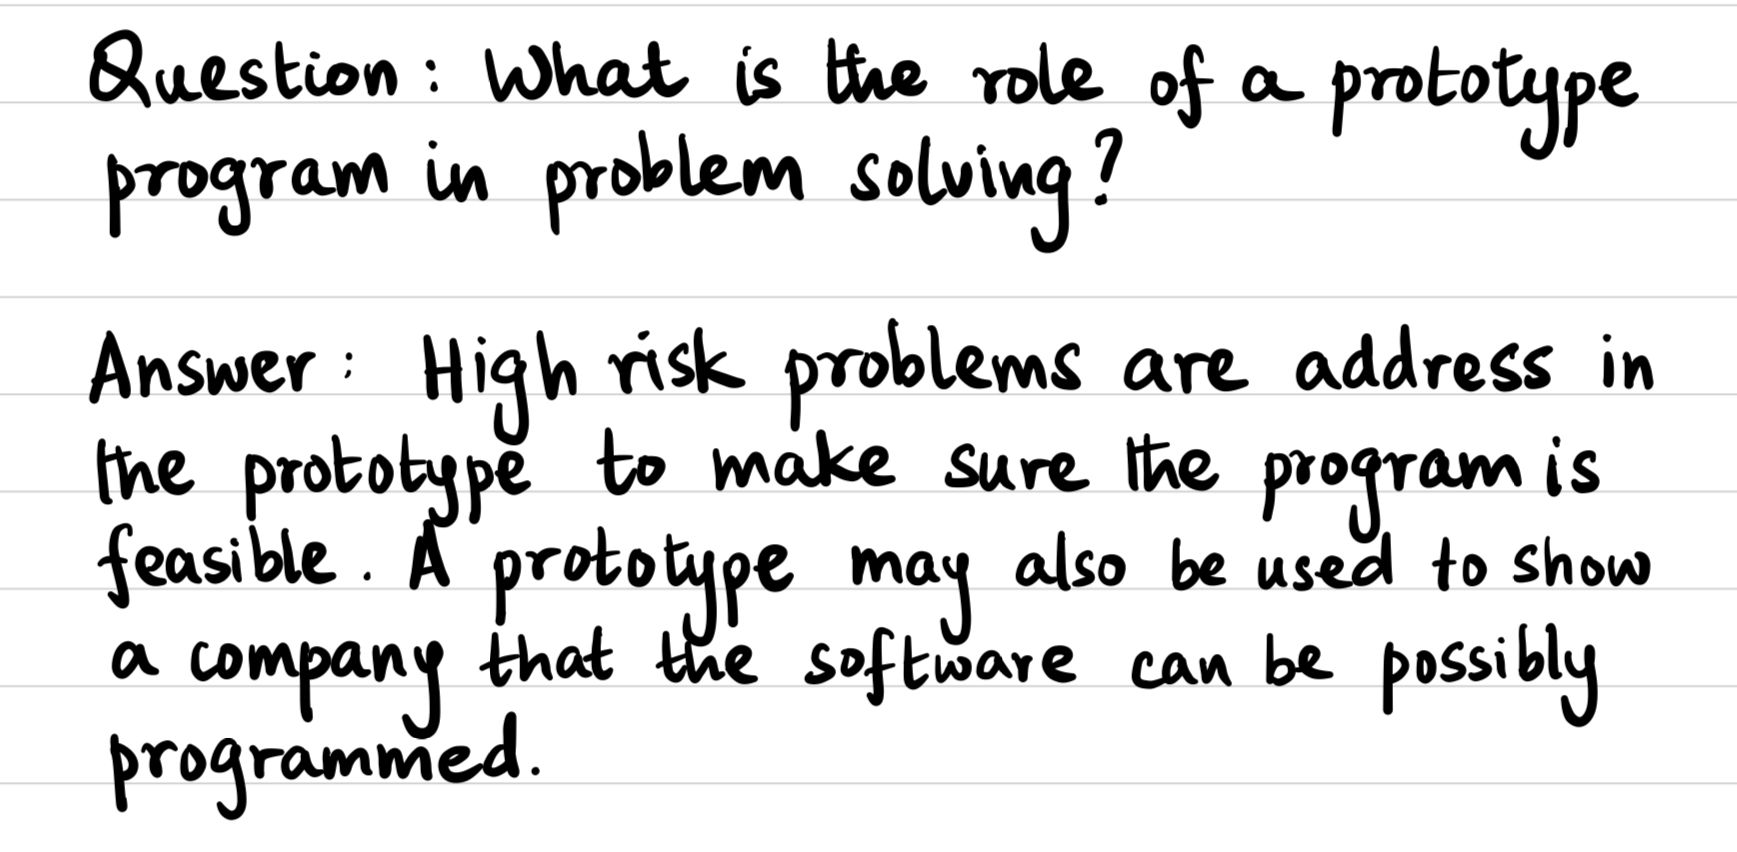

In [ ]:
# def get_prediction_from_image(model, image_path_in_colab):

image_path_in_colab='/content/image.jpeg'

extractedInformation = pytesseract.image_to_string(Image.open(image_path_in_colab))
display(Image.open(image_path_in_colab))
my_given_answer = extractedInformation.split('Answer: ')[-1]
my_given_answer = my_given_answer.replace('\n', ' ')
my_given_question = extractedInformation.split('Answer: ')[0].split('Question: ')[-1]
my_given_question = my_given_question.replace('\n', ' ')
df = mohler_df.copy()

df['similarity_score'] = df['question'].apply(lambda x: fuzz.partial_ratio(my_given_question, x))


In [ ]:
# Find the row with the highest similarity score
max_row = df[df['similarity_score'] == df['similarity_score'].max()]


In [ ]:
my_expect_answer = max_row.iloc[0,2]
premise = "You are a grader for a undergraduate computer science course. For the given 'Question', analyze the 'Given Answer' against the 'Expected Answer' and provide a score based on the relevancy of the answer."
question_prefix = "'Question': "
given_prefix = "'Given Answer': "
expect_prefix = "'Expected Answer': "
guard_rails = "Provide your score on the given scale. In order of least relevant answer to most relevant, the score can be one of the following: 'Incorrect', 'Poor', 'Fair', 'Adequate', 'Good', 'Excellent'. Do not display any other content other than the single score word."

mohler_input = premise + question_prefix + my_given_question + expect_prefix + my_expect_answer + given_prefix + my_given_answer + guard_rails
print(mohler_input)

inputs = tokenizer(mohler_input, return_tensors="pt")
model = model.to('cpu')
outputs = model.generate(**inputs)
answer = tokenizer.decode(outputs[0])
from textwrap import fill

true_score = max_row.iloc[0, 5]
print("True Score: ", true_score)
print("Predicted Score: ", fill(answer, width=80))

# get_prediction_from_image(model, image_path_in_colab)

You are a grader for a undergraduate computer science course. For the given 'Question', analyze the 'Given Answer' against the 'Expected Answer' and provide a score based on the relevancy of the answer.'Question': What is tke vole of O prototype program ln problem Solving 7  'Expected Answer': To simulate the behaviour of portions of the desired software product'Given Answer': High risk problems are address in tne prokorape te make Sure the program is feasible . provedre may also be used to Show a compan that the Sof Lwave can be possibly programmed. Provide your score on the given scale. In order of least relevant answer to most relevant, the score can be one of the following: 'Incorrect', 'Poor', 'Fair', 'Adequate', 'Good', 'Excellent'. Do not display any other content other than the single score word.
True Score:  Good
Predicted Score:  <pad> Good</s>


# References
- https://www.datacamp.com/tutorial/flan-t5-tutorial
- https://github.com/VanekPetr/flan-t5-text-classifier/tree/main/classifier